In [1]:
#!/usr/bin/env python3
import sys
import requests

import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy import optimize

from sgp4.api import Satrec

import astropy.units as u
from astropy.io import ascii
from astropy.time import Time
from astropy.coordinates import SkyCoord, FK5, GCRS, EarthLocation, AltAz
from astropy.coordinates import CartesianRepresentation, CartesianDifferential, TEME

import lofarantpos
from lofarantpos.db import LofarAntennaDatabase

if __name__ == "__main__xxx":
    # Input settings
    sourcefname = "sources.csv"
    tstart_isot = "2022-12-09T12:00:00"
    duration_s = 12*60*60
#    satno = 33591
#    satno = 25338
#    satno = 28654
    satno = 40069

    # Satellites
    # NOAA 15:    25338 APT at 137.620MHz
    # NOAA 18:    28654 APT at 137.912MHz
    # NOAA 19:    33591 APT at 137.100MHz
    # Meteor M-2: 40069 LRPT at 137.100MHz
    
    # Read sources
    d = ascii.read(sourcefname, format="csv")
    psrc = SkyCoord(ra=d["ra"], dec=d["dec"], unit=("hourangle", "deg"), frame="icrs")
    names = d["name"]
    
    # Compute satellite passes
    t = Time(tstart_isot, format="isot", scale="utc") + np.arange(duration_s) * u.s
    
    # Download TLE
    resp = requests.get(f"http://celestrak.org/NORAD/elements/gp.php?CATNR={satno:05d}")
    lines = resp.content.decode("utf-8").splitlines()

    # Satellite position and velocity
    sat = Satrec.twoline2rv(lines[1], lines[2])
    _, teme_p, teme_v = sat.sgp4_array(t.jd1, t.jd2)
    teme_p = CartesianRepresentation(teme_p.T*u.km)
    teme = TEME(teme_p, obstime=t)

    # Reference location
    db = LofarAntennaDatabase()
    loc = EarthLocation.from_geocentric(*(db.phase_centres["CS001HBA0"] * u.m))
    
    # To altaz
    gloc = loc.get_gcrs(obstime=t)
    g = teme.transform_to(GCRS(obstime=t, obsgeoloc=gloc.cartesian))
    a = teme.transform_to(AltAz(obstime=t, location=loc))

    # Find maximum pass
    idx = np.argmax(a.alt.degree)
    tmax = t[idx]
    amax = a[idx].alt.degree
    dt = 600 * u.s
    if amax < 60:
        print("No passes above 60 degrees found")
        sys.exit()
    print("altmax %s %.1f @ %.3f %.3f"%(t[idx].isot,amax,a[idx].az.degree,a[idx].alt.degree))
    # Select points above altitude limit
    c = (a.alt.degree > 30) & (np.abs((t - tmax).to(u.s)) < dt)

    # Loop over sources
    for p, name in zip(psrc, names):
        # Setup interpolating functions
        fdec = interpolate.interp1d(t[c].mjd, g[c].dec.degree - p.dec.degree)
        faz = interpolate.interp1d(t[c].mjd, a[c].az.degree)
        falt = interpolate.interp1d(t[c].mjd, a[c].alt.degree)

        # Time extrema
        tmin, tmax = np.min(t[c]), np.max(t[c])
        print(name,tmin,tmax)
        # Find pass
        mjdpass = optimize.bisect(fdec, tmin.mjd, tmax.mjd)
        tpass = Time(mjdpass, format="mjd")
        apass = AltAz(az=faz(mjdpass) * u.deg, alt=falt(mjdpass) * u.deg, obstime=tpass, location=loc)
        gpass = apass.transform_to(GCRS(obstime=tpass))

        sra = gpass.ra.to_string(unit="hourangle", sep=":", precision=2, pad=True)
        sdec = gpass.dec.to_string(unit="deg", sep=":", precision=1, alwayssign=True, pad=True)
        
        print(f"{name} {tpass.isot} {apass.az.degree:7.3f} {apass.alt.degree:6.3f} {sra} {sdec}")


In [2]:
sourcefname = "sources.csv"
tstart_isot = "2022-12-09T12:00:00"
tstep_s=10
duration_s = 3*24*60*60/tstep_s
    
# Compute satellite passes
t = Time(tstart_isot, format="isot", scale="utc") + np.arange(duration_s) *tstep_s* u.s


In [3]:
# Reference location
db = LofarAntennaDatabase()
loc = EarthLocation.from_geocentric(*(db.phase_centres["CS001HBA0"] * u.m))
gloc = loc.get_gcrs(obstime=t)
print(loc)

(3826896.631, 460979.131, 5064657.943) m


In [4]:
sat_ids0=[25338,28654,33591,40069]
from satellite_tle import fetch_latest_tles
sat_tles=fetch_latest_tles(sat_ids0)
print(sat_tles)

{25338: ('Celestrak (SatNOGS)', ('NOAA 15', '1 25338U 98030A   22345.84853012  .00000158  00000+0  83959-4 0  9999', '2 25338  98.6271  12.9212 0011125 136.6397 223.5660 14.26206423278302')), 28654: ('Celestrak (SatNOGS)', ('NOAA 18', '1 28654U 05018A   22345.82750070  .00000208  00000+0  13595-3 0  9999', '2 28654  98.9320  55.9687 0014287 186.4992 173.5997 14.12819902905023')), 33591: ('Celestrak (SatNOGS)', ('NOAA 19', '1 33591U 09005A   22345.84915018  .00000173  00000+0  11812-3 0  9993', '2 33591  99.1275  23.5413 0014571  52.5581 307.6913 14.12649648713238')), 40069: ('Celestrak (SatNOGS)', ('METEOR-M 2', '1 40069U 14037A   22345.65824988  .00000019  00000+0  27766-4 0  9991', '2 40069  98.4265 355.3350 0006016 156.9237 203.2214 14.20729228437022'))}


In [5]:
# Satellite position and velocity
altaz=[]
for satid in sat_ids0:
    print(satid)
    lines=sat_tles[satid][1]
    sat = Satrec.twoline2rv(lines[1], lines[2])
    _, teme_p, teme_v = sat.sgp4_array(t.jd1, t.jd2)
    teme_p = CartesianRepresentation(teme_p.T*u.km)
    teme = TEME(teme_p, obstime=t)
    
    # To altaz
#    g = teme.transform_to(GCRS(obstime=t, obsgeoloc=gloc.cartesian))
    a = teme.transform_to(AltAz(obstime=t, location=loc))
    altaz.append(a)

25338
28654
33591
40069


In [36]:
flyovers=[]
Nsat=len(sat_ids0)
for i in range(Nsat):
    alt=altaz[i].alt.degree
    grad=alt[1:]-alt[:-1]
    peak=(grad[:-1]>0)*(grad[1:]<0)*(alt[1:-1]>55)#40
    peak_index=np.compress(peak,np.array(range(len(peak))))+1
    for x in peak_index:
        flyovers.append([sat_ids0[i],i,x,t[x].isot,altaz[i][x].alt.degree])
        print(sat_tles[sat_ids0[i]][1][0],t[x].isot,altaz[i][x].alt.degree)
#for a in flyovers: print(a)

NOAA 15 2022-12-09T18:06:20.000 77.62420720391465
NOAA 15 2022-12-10T07:54:40.000 81.60027736242054
NOAA 15 2022-12-11T07:29:20.000 66.29419173806185
NOAA 18 2022-12-10T10:28:00.000 72.71982062296354
NOAA 18 2022-12-11T10:15:50.000 59.57420059009624
NOAA 19 2022-12-09T19:19:50.000 61.39711703527107
NOAA 19 2022-12-10T19:07:50.000 74.72598834579675
NOAA 19 2022-12-11T09:04:00.000 56.3791942079123
NOAA 19 2022-12-11T18:56:00.000 88.45026353783147
NOAA 19 2022-12-12T08:52:10.000 68.10303208952573
METEOR-M 2 2022-12-09T16:43:40.000 61.80130657995915
METEOR-M 2 2022-12-10T06:35:10.000 86.75882005456839
METEOR-M 2 2022-12-11T06:15:10.000 63.01974879851277


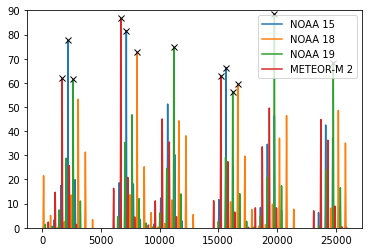

In [25]:
for i,pos in enumerate(altaz):
    alt=pos.alt.degree
    plt.plot(alt,label=sat_tles[sat_ids0[i]][1][0])
    plt.ylim(0,90)
for a in flyovers: plt.plot(a[2],a[4],'kx')
plt.legend()

In [26]:
filename='Sats_%s_%i'%(tstart_isot,tstep_s)
print(filename)
if True:
    alts=[pos.alt.degree for pos in altaz]
    azs=[pos.az.degree for pos in altaz]
    np.savez(filename,sat_tles=sat_tles,alt=alts,az=azs,flyovers=flyovers,time=t.isot)
else:
    Data=np.load(filename+".npz",allow_pickle=True)
    #sat_tles=Data['sat_tles']
    alts=Data['alt']
    azs=Data['az']
    t= Time(Data['time'],format="isot", scale="utc")
    flyovers=Data['flyovers']

Sats_2022-12-09T12:00:00_10


In [27]:
d = ascii.read(sourcefname, format="csv")
psrc = SkyCoord(ra=d["ra"], dec=d["dec"], unit=("hourangle", "deg"), frame="icrs")
names = d["name"]
print(names)

 name
-----
Cas A
Cyg A
   B3
   B4
  NCP
   B5


(-1.0, 1.0, -1.0, 1.0)

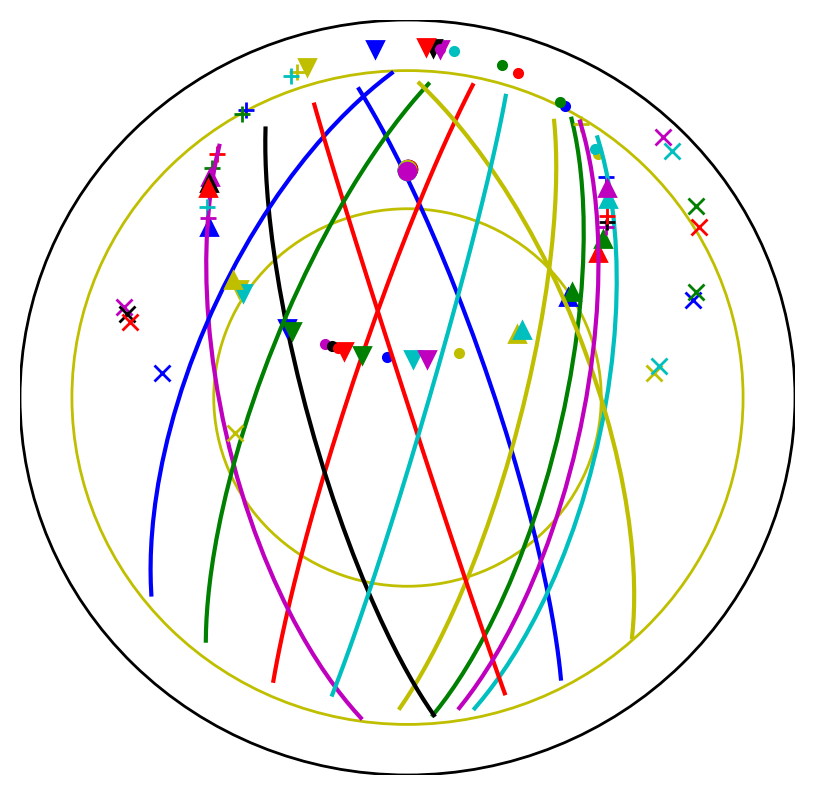

In [28]:
plt.figure(dpi=200,figsize=(5,5))
ax = plt.gca()
ax.add_patch(plt.Circle((0, 0), 1.0, color='k',fill=False))
ax.add_patch(plt.Circle((0, 0), 0.5, color='y',fill=False))
ax.add_patch(plt.Circle((0, 0), np.cos(30/180*np.pi), color='y',fill=False))
colors=['b','r','g','y','c','m','k']
symbols=['.','x','^','v','o','+']
for cnt,[satid,satidx,idx,time0,alt0] in enumerate(flyovers):
#    t0=t[idx-100:idx+100].unix-t[idx].unix
    idx=int(idx)
    satidx=int(satidx)
    satid=int(satid)
    for cnt2,p in enumerate(psrc):
        a = p.transform_to(AltAz(obstime=t[idx], location=loc))
        X=np.cos(a.alt.rad)*np.sin(a.az.rad)
        Y=np.cos(a.alt.rad)*np.cos(a.az.rad)
        plt.plot(X,Y,colors[cnt%len(colors)]+symbols[cnt2],label=names[cnt2] if cnt==0 else '')

    alt=alts[satidx][idx-15:idx+15]/180*np.pi
    az=azs[satidx][idx-15:idx+15]/180*np.pi
    X=np.cos(alt)*np.sin(az)/(alt>30/180*np.pi)
    Y=np.cos(alt)*np.cos(az)/(alt>30/180*np.pi)
#    print(,satid)
    plt.plot(X,Y,colors[cnt%len(colors)],label='%s %s'%(sat_tles[satid][1][0],time0))

#plt.legend(fontsize=6,ncol=2,loc='lower left')
#plt.grid()
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axis('off')

0
1
2
3
4
5
6
7
8
9
10
11
12


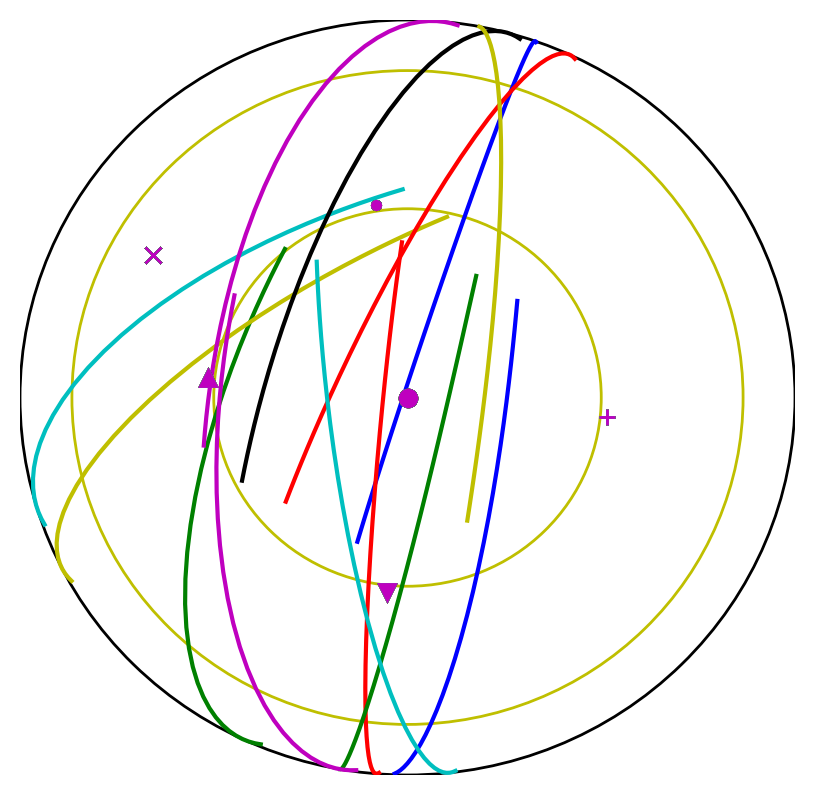

In [29]:
plt.figure(dpi=200,figsize=(5,5))
ax = plt.gca()
ax.add_patch(plt.Circle((0, 0), 1.0, color='k',fill=False))
ax.add_patch(plt.Circle((0, 0), 0.5, color='y',fill=False))
ax.add_patch(plt.Circle((0, 0), np.cos(30/180*np.pi), color='y',fill=False))
colors=['b','r','g','y','c','m','k']
symbols=['.','x','^','v','o','+']
for cnt,[satid,satidx,idx,time0,alt0] in enumerate(flyovers):
#    t0=t[idx-100:idx+100].unix-t[idx].unix
    idx=int(idx)
    print(cnt)
    satidx=int(satidx)
    satid=int(satid)
    for cnt2,p in enumerate(psrc):
        a = p.transform_to(GCRS(obstime=t[idx], obsgeoloc=gloc[idx].cartesian))
        X=np.cos(a.dec.rad)*np.sin(a.ra.rad)
        Y=np.cos(a.dec.rad)*np.cos(a.ra.rad)
        plt.plot(X,Y,colors[cnt%len(colors)]+symbols[cnt2],label=names[cnt2] if cnt==0 else '')
    alt=[]
    az=[]
    
    for i in range(idx-20,idx+20):
      if (i<0) or (i>=len(t)): continue;
      A=altaz[satidx][i]
#      print(A,t[i])
      if A.alt.degree<30: continue;
      A=A.transform_to(GCRS(obstime=t[i],obsgeoloc=gloc[i].cartesian))
#      A=A.transform_to(FK5(obstime=t[i]))
      alt.append(A.dec.rad)
      az.append(A.ra.rad)
    alt=np.array(alt)        
    az=np.array(az)        
#    az=azs[satidx][idx-200:idx+200]/180*np.pi
    X=np.cos(alt)*np.sin(az)
    Y=np.cos(alt)*np.cos(az)
#    print(,satid)
#    print(X,Y)
    plt.plot(X,Y,colors[cnt%len(colors)],label='%s %s'%(sat_tles[satid][1][0],time0))

#plt.legend(fontsize=6,ncol=2,loc='lower left')
#plt.grid()
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axis('off');

In [30]:
from sst_bst import SSTs
from datetime import datetime
sst=SSTs('sst')
def P2dB(X): return 10*np.log10(X)
sis=range(8*3,12*3)

In [31]:
sat_freq=[137.62,137.9,137.1,137.1]
sat_ids0=[25338,28654,33591,40069]

print("Sat freq (MHz):",sat_freq)

freqs=200-np.arange(512)/512*100
sat_band=np.array([np.argmin(np.abs(freqs-freq1)) for freq1 in sat_freq])


Sat freq (MHz): [137.62, 137.9, 137.1, 137.1]


Load SST sst/SST_2022-12-09-17-51-34.h5
(30, 12)
Load SST sst/SST_2022-12-10-07-51-34.h5
(30, 12)
Load SST sst/SST_2022-12-10-09-51-34.h5
(30, 12)
Load SST sst/SST_2022-12-09-18-51-34.h5
(30, 12)
Load SST sst/SST_2022-12-11-18-24-57.h5
(30, 12)
Load SST sst/SST_2022-12-09-15-51-34.h5
(30, 12)
Load SST sst/SST_2022-12-10-05-51-34.h5
(30, 12)
13 13


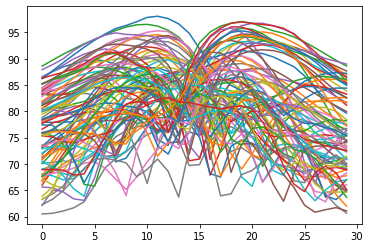

In [45]:
from datetime import timedelta
tstep=10 #3 second avg
sst_data=[]
for cnt,[satid,satidx,idx,time0,alt0] in enumerate(flyovers):
#for i,tstart,tend in peak_list:
    tstart=datetime.fromisoformat(t[idx-15].isot)-timedelta(seconds=tstep/2)
    tend=datetime.fromisoformat(t[idx+15].isot)-timedelta(seconds=tstep/2)
    D=sst.getData(tstart,tend,sis,sat_band[satidx]) #second data
    if len(D)==0:
        sst_data.append(None)
        continue;
    n1,n2=D.shape
    na=n1//tstep
    D=np.mean(D[:na*tstep].reshape([na,tstep,n2]),axis=1)
    sst_data.append(D)
    print(D.shape)
    plt.plot(P2dB(D))
    
print(len(flyovers),len(sst_data))

/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * 

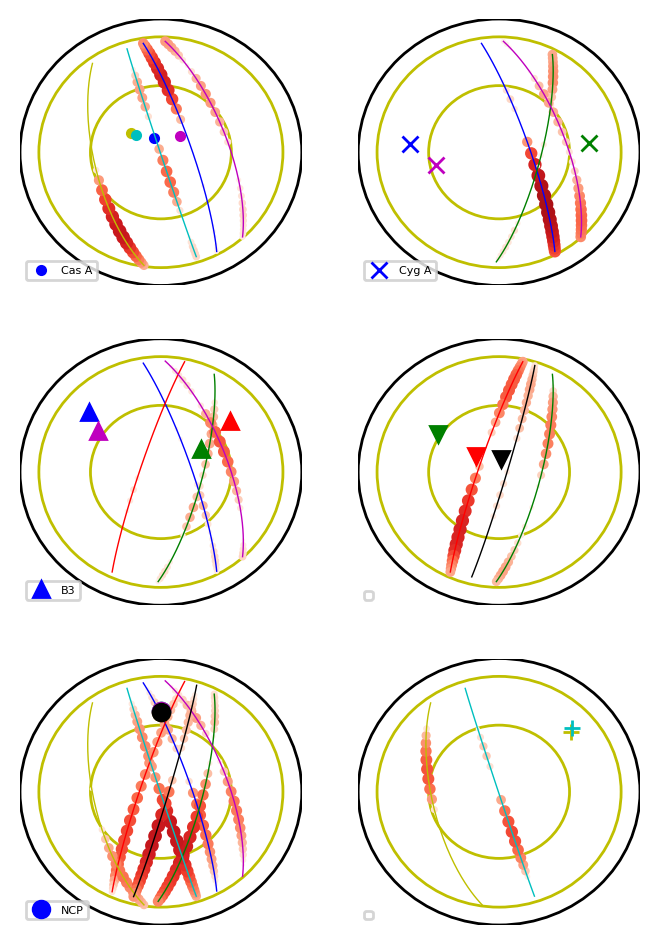

In [46]:
plt.figure(dpi=200,figsize=(4,6))
for x in range(6):
    plt.subplot(3,2,x+1)
    ax = plt.gca()
    ax.add_patch(plt.Circle((0, 0), 1.0, color='k',fill=False))
    ax.add_patch(plt.Circle((0, 0), 0.5, color='y',fill=False))
    ax.add_patch(plt.Circle((0, 0), np.cos(30/180*np.pi), color='y',fill=False))
colors=['b','r','g','y','c','m','k']
symbols=['.','x','^','v','o','+']
pltcnt=0
for cnt,[satid,satidx,idx,time0,alt0] in enumerate(flyovers):
    if sst_data[cnt] is None: continue;

#    t0=t[idx-100:idx+100].unix-t[idx].unix
    idx=int(idx)
    satidx=int(satidx)
    satid=int(satid)

    alt=alts[satidx][idx-15:idx+15]/180*np.pi
    az=azs[satidx][idx-15:idx+15]/180*np.pi
    mask=alt>30/180*np.pi
    X=np.cos(alt)*np.sin(az)#/(alt>30/180*np.pi)
    X=X.compress(mask)
    Y=np.cos(alt)*np.cos(az)#/(alt>30/180*np.pi)
    Y=Y.compress(mask)
#    print(,satid)
    D2=P2dB(sst_data[cnt])-80-1*P2dB(np.sin(alt))[:,np.newaxis]

#    for cnt2,p in enumerate(psrc):
    for x in range(6):
        plt.subplot(3,2,x+1)
        a = psrc[x].transform_to(AltAz(obstime=t[idx], location=loc))
        if a.alt.rad<45/180*np.pi: continue
        X1=np.cos(a.alt.rad)*np.sin(a.az.rad)
        Y1=np.cos(a.alt.rad)*np.cos(a.az.rad)
#        plt.subplot(3,2,cnt2+1)
        plt.plot(X1,Y1,colors[pltcnt%len(colors)]+symbols[x],label=names[x] if cnt==0 else '')
#        plt.plot(-X,-Y,colors[cnt]+'.',markersize=3)

        z=D2[:,x*2] #np.compress(mask, D2[:,0])
        if len(z)!=len(mask):
            print(z.shape,mask.shape)
            continue;
        z=z.compress(mask)
#        plt.plot(X,Y,colors[cnt],label='%s %s'%(sat_tles[satid][1][0],time0),linewidth=0.5)
        plt.plot(X,Y,colors[pltcnt%len(colors)],linewidth=0.5)
        plt.scatter(X,Y,s=z,c=z,cmap='Reds',vmin=0,vmax=20)    
    pltcnt+=1

#    plt.plot(X,Y,colors[cnt],label='%s %s'%(sat_tles[satid][1][0],time0))

#plt.grid()
for x in range(6):
    plt.subplot(3,2,x+1)
    plt.legend(fontsize=4,ncol=1,loc='lower left')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.axis('off')

0


/tmp/ipykernel_2192784/3548591622.py:4: RuntimeWarning: invalid value encountered in log10
  def P2dB(X): return 10*np.log10(X)
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


1


/tmp/ipykernel_2192784/3548591622.py:4: RuntimeWarning: invalid value encountered in log10
  def P2dB(X): return 10*np.log10(X)
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


2
3


/tmp/ipykernel_2192784/3548591622.py:4: RuntimeWarning: invalid value encountered in log10
  def P2dB(X): return 10*np.log10(X)
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


4
5


/tmp/ipykernel_2192784/3548591622.py:4: RuntimeWarning: invalid value encountered in log10
  def P2dB(X): return 10*np.log10(X)
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


6
7
8


/tmp/ipykernel_2192784/3548591622.py:4: RuntimeWarning: invalid value encountered in log10
  def P2dB(X): return 10*np.log10(X)
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


9
10


/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


11


/tmp/ipykernel_2192784/3548591622.py:4: RuntimeWarning: invalid value encountered in log10
  def P2dB(X): return 10*np.log10(X)
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


12


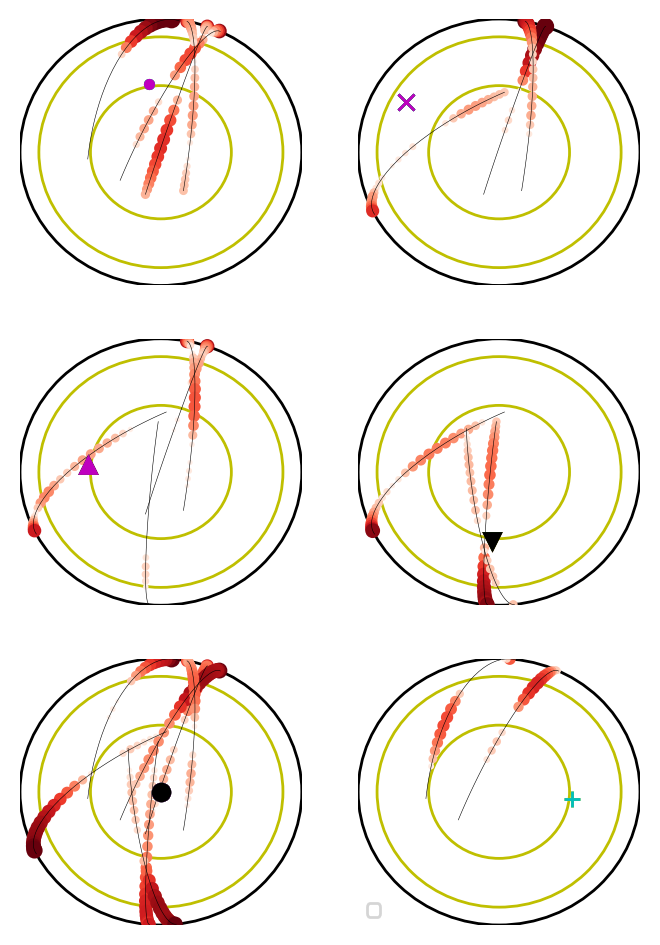

In [48]:
plt.figure(dpi=200,figsize=(4,6))
for x in range(6):
    plt.subplot(3,2,x+1)
    ax = plt.gca()
    ax.add_patch(plt.Circle((0, 0), 1.0, color='k',fill=False))
    ax.add_patch(plt.Circle((0, 0), 0.5, color='y',fill=False))
    ax.add_patch(plt.Circle((0, 0), np.cos(30/180*np.pi), color='y',fill=False))
colors=['b','r','g','y','c','m','k']
symbols=['.','x','^','v','o','+']
pltcnt=0
for cnt,[satid,satidx,idx,time0,alt0] in enumerate(flyovers):
#    t0=t[idx-100:idx+100].unix-t[idx].unix
    idx=int(idx)
    print(cnt)
    satidx=int(satidx)
    satid=int(satid)
    if sst_data[cnt] is None: continue;

    alt=[]
    az=[]
    alt0=[]
    for i in range(idx-15,idx+15):
      if (i<0) or (i>=len(t)): continue;
      A=altaz[satidx][i]
#      print(A,t[i])
#      if A.alt.degree<30: continue;
      alt0.append(A.alt.rad)
      A=A.transform_to(GCRS(obstime=t[i],obsgeoloc=gloc[i].cartesian))
#      A=A.transform_to(FK5(obstime=t[i]))
      alt.append(A.dec.rad)
      az.append(A.ra.rad)
    alt=np.array(alt)        
    alt0=np.array(alt0)        
    mask=alt0>30/180*np.pi
    
    az=np.array(az)        
#    az=azs[satidx][idx-200:idx+200]/180*np.pi
    X=np.cos(alt)*np.sin(az)
    X=X.compress(mask)
    Y=np.cos(alt)*np.cos(az)
    Y=Y.compress(mask)
#    print(,satid)
#    print(X,Y)
    D2=P2dB(sst_data[cnt])-80-1*P2dB(np.sin(alt))[:,np.newaxis]
    for x in range(6):
    #for cnt2,p in enumerate(psrc):
        plt.subplot(3,2,x+1)
        a = psrc[x].transform_to(GCRS(obstime=t[idx], obsgeoloc=gloc[idx].cartesian))
        b = psrc[x].transform_to(AltAz(obstime=t[idx], location=loc))
        if b.alt.rad<45/180*np.pi: continue

        X1=np.cos(a.dec.rad)*np.sin(a.ra.rad)
        Y1=np.cos(a.dec.rad)*np.cos(a.ra.rad)
#        plt.subplot(3,2,cnt2+1)
        plt.plot(X1,Y1,colors[pltcnt%len(colors)]+symbols[x],label=names[x] if cnt==0 else '')

        z=D2[:,x*2] #np.compress(mask, D2[:,0])
        if len(z)!=len(mask):
            print(z.shape,X.shape)
            continue;
        z=z.compress(mask)
        plt.scatter(X,Y,s=z,c=z,cmap='Reds',vmin=0,vmax=20)    
        plt.plot(X,Y,'k-',linewidth=0.2)
    pltcnt+=1;
plt.legend(fontsize=6,ncol=2,loc='lower left')
#plt.grid()
for x in range(6):
    plt.subplot(3,2,x+1)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.axis('off');